In [1]:
%run resources/library.py

# Notebook 6: Counting Soho District Building Footprints in Voronoi Cells

In [2]:
import osmnx as ox

ox.__version__

'1.1.1'

## Using OSMNx `footprints` feature

Let's assume that most buildings in 1854 Soho district are still intact and have footprints accessible through OSMNx. Let's use the SOHO_COORDINATES from the Cholera Basic Notebooks as a starting point for retrieving building footprints (polygons) using OSMNx `footprints` feature.

In [3]:
SOHO_COORDINATES = (51.513578, -0.136722)

In [4]:
# radius of 700m
distance = 700
footprints_gdf = \
   ox.geometries.geometries_from_point(SOHO_COORDINATES, dist=distance, \
                tags={'building':True}).to_crs(epsg=3395)

In [5]:
footprints_gdf.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's look at the `geometry` column - these are the building footprint polygons.

In [6]:
footprints_gdf = footprints_gdf[footprints_gdf['geometry'].notnull()]

footprints_gdf.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
footprints_gdf['geometry'].head()

element_type  osmid     
node          691114555     POINT (-15379.233 6679774.449)
              701600760     POINT (-15390.042 6679250.295)
              1265087044    POINT (-15805.720 6679811.062)
              1586686914    POINT (-14192.523 6678981.434)
              2624953196    POINT (-15215.961 6678883.400)
Name: geometry, dtype: geometry

<AxesSubplot:>

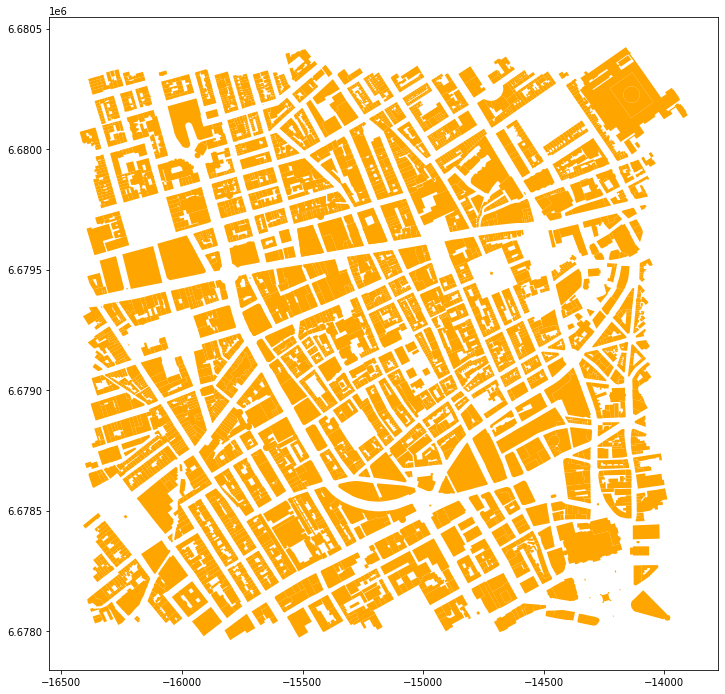

In [8]:
footprints_gdf['geometry'].plot(figsize=(14,12), color='orange')

In [9]:
footprints_gdf['geometry'].centroid

element_type  osmid     
node          691114555     POINT (-15379.233 6679774.449)
              701600760     POINT (-15390.042 6679250.295)
              1265087044    POINT (-15805.720 6679811.062)
              1586686914    POINT (-14192.523 6678981.434)
              2624953196    POINT (-15215.961 6678883.400)
                                         ...              
relation      9261429       POINT (-16017.983 6679909.898)
              9261564       POINT (-16156.285 6679932.684)
              9324344       POINT (-16383.382 6680054.570)
              13025451      POINT (-15199.076 6679648.525)
              13025452      POINT (-15230.319 6679719.713)
Length: 3714, dtype: geometry

In [10]:
import geopandas as gpd

gpd.__version__

'0.9.0'

## Creating a geodataframe of footprint centroids

The footprint feature of OSMNx allows you to plot polygons of buildings. But to determine if buildings are inside (belongs to) pump voronoi cells, we need to identify buildings by the centroid of its polygon vertices. Fortunately, `geometry` columns in Geopandas are native `shapely` objects. We can get polygon centroids by the attribute `centroid`.

In [11]:
footprints_centroid_gdf = gpd.GeoDataFrame(\
                            geometry=footprints_gdf['geometry'].centroid)\
                            .reset_index()\
                            .rename(columns={'index':'osmid'})

footprints_centroid_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3714 entries, 0 to 3713
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   element_type  3714 non-null   object  
 1   osmid         3714 non-null   int64   
 2   geometry      3714 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 87.2+ KB


In [12]:
footprints_centroid_gdf.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

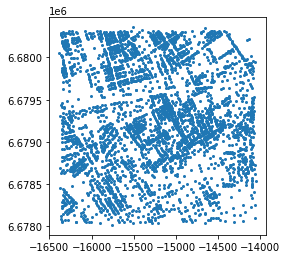

In [13]:
footprints_centroid_gdf.geometry.plot(markersize=4)

## Amplified cognition: Geopandas plots and computational geometry tricks

Because of of the different kinds of data that we already have, what if we could draw a Geopandas plot that looks like this?

![](images/subplots_overlay.png)

### Inventory of geodataframes and dataframes to use

Steps to draw this plot, layer by layer (bottom to top):

1. Building footprints, as  polygons, minus footprint polygons within pump Voronoi cells
2. Building footprints, as centroids (points), minus footprint centroids outside pump Voronoi cells
3. Building footprints, centroids within pump Voronoi cells
4. Pump Voronoi cells (clipped)
5. Street pumps

Let's reload the `clipped_voronoi_gdf` geodataframe. This is what we will use for geopandas `sjoin()` and `overlay()` functions. 

In [14]:
clipped_voronoi_gdf = gpd.read_file('outputs/clipped_voronoi.shp').to_crs(epsg=3395)

In [15]:
clipped_voronoi_gdf

,vorpoint_l,vorpoint_1,FID,Street,geometry
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-15008.714 6679933.633, -14986.067 6..."
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-15755.504 6678886.043, -15769.854 6..."
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-15764.064 6679503.520, -15757.904 6..."
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-14465.257 6679153.299, -14454.588 6..."
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-14835.933 6679867.746, -14824.464 6..."
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-15225.480 6678323.299, -15265.465 6..."
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-14755.051 6678292.781, -14771.209 6..."
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-15448.443 6678430.903, -15470.469 6..."


In [16]:
clipped_voronoi_gdf.rename(\
            columns={'vorpoint_l':'vorpt_lat',\
                     'vorpoint_1':'vorpt_lon',\
                     'points_in_polygon':'pts_in_vor'
                    }, inplace=True)

In [17]:
clipped_voronoi_gdf.geometry.to_crs('EPSG:3395')

0    POLYGON ((-15008.714 6679933.633, -14986.067 6...
1    POLYGON ((-15755.504 6678886.043, -15769.854 6...
2    POLYGON ((-15764.064 6679503.520, -15757.904 6...
3    POLYGON ((-14465.257 6679153.299, -14454.588 6...
4    POLYGON ((-14835.933 6679867.746, -14824.464 6...
5    POLYGON ((-15225.480 6678323.299, -15265.465 6...
6    POLYGON ((-14755.051 6678292.781, -14771.209 6...
7    POLYGON ((-15448.443 6678430.903, -15470.469 6...
Name: geometry, dtype: geometry

In [18]:
clipped_voronoi_gdf

,vorpt_lat,vorpt_lon,FID,Street,geometry
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-15008.714 6679933.633, -14986.067 6..."
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-15755.504 6678886.043, -15769.854 6..."
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-15764.064 6679503.520, -15757.904 6..."
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-14465.257 6679153.299, -14454.588 6..."
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-14835.933 6679867.746, -14824.464 6..."
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-15225.480 6678323.299, -15265.465 6..."
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-14755.051 6678292.781, -14771.209 6..."
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-15448.443 6678430.903, -15470.469 6..."


In [19]:
clipped_voronoi_gdf.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
footprints_gdf.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
footprints_gdf.geometry

element_type  osmid     
node          691114555                        POINT (-15379.233 6679774.449)
              701600760                        POINT (-15390.042 6679250.295)
              1265087044                       POINT (-15805.720 6679811.062)
              1586686914                       POINT (-14192.523 6678981.434)
              2624953196                       POINT (-15215.961 6678883.400)
                                                  ...                        
relation      9261429       POLYGON ((-16102.131 6679934.657, -16055.777 6...
              9261564       POLYGON ((-16138.744 6679963.562, -16124.940 6...
              9324344       POLYGON ((-16370.244 6680027.422, -16371.646 6...
              13025451      POLYGON ((-15249.557 6679671.393, -15181.407 6...
              13025452      POLYGON ((-15274.281 6679736.606, -15205.920 6...
Name: geometry, Length: 3714, dtype: geometry

In [22]:
footprints_gdf = footprints_gdf[footprints_gdf['geometry'].apply(lambda x : x.type!='Point' )]

footprints_gdf.geometry

element_type  osmid   
way           4372002     POLYGON ((-14228.534 6678416.193, -14292.432 6...
              10811256    POLYGON ((-16035.806 6680085.625, -16030.630 6...
              26706806    POLYGON ((-15823.609 6678003.795, -15817.231 6...
              27922125    POLYGON ((-15930.253 6680025.869, -15926.424 6...
              28416536    POLYGON ((-14276.714 6679919.990, -14273.886 6...
                                                ...                        
relation      9261429     POLYGON ((-16102.131 6679934.657, -16055.777 6...
              9261564     POLYGON ((-16138.744 6679963.562, -16124.940 6...
              9324344     POLYGON ((-16370.244 6680027.422, -16371.646 6...
              13025451    POLYGON ((-15249.557 6679671.393, -15181.407 6...
              13025452    POLYGON ((-15274.281 6679736.606, -15205.920 6...
Name: geometry, Length: 3702, dtype: geometry

In [23]:
clipped_voronoi_gdf.geometry

0    POLYGON ((-15008.714 6679933.633, -14986.067 6...
1    POLYGON ((-15755.504 6678886.043, -15769.854 6...
2    POLYGON ((-15764.064 6679503.520, -15757.904 6...
3    POLYGON ((-14465.257 6679153.299, -14454.588 6...
4    POLYGON ((-14835.933 6679867.746, -14824.464 6...
5    POLYGON ((-15225.480 6678323.299, -15265.465 6...
6    POLYGON ((-14755.051 6678292.781, -14771.209 6...
7    POLYGON ((-15448.443 6678430.903, -15470.469 6...
Name: geometry, dtype: geometry

### Geometry intersection using `overlay()`

We will use Geopandas' `overlay` function to perform computational geometry tasks. You can go this [link](http://geopandas.org/set_operations.html) to learn more about this. The intersection operation below creates a part of the footprint landscape in the shape of the clipped Voronoi cells.

/opt/conda/lib/python3.9/site-packages/geopandas/geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)


<AxesSubplot:>

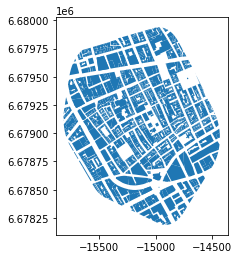

In [24]:
intersection = gpd.overlay(footprints_gdf, clipped_voronoi_gdf, how='intersection', keep_geom_type=True, make_valid=True)

intersection.plot()

### Geometry difference using `overlay()`

The performance of the `difference` function results in a plot of the building footprints minus the area that falls under the clipped Voronoi cells.

<AxesSubplot:>

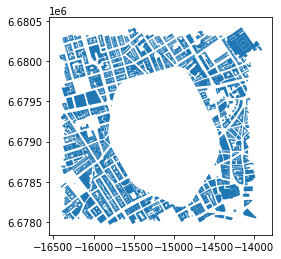

In [25]:
difference1 = gpd.overlay(footprints_gdf, clipped_voronoi_gdf, how='difference')

difference1.plot()

### Point geometry within polygon geometry using Geopandas `sjoin()`

The next difference operation is between geometries for building centroids (`footprints_centroid_gdf`, `shapely` points) and the clipped Voronoi polygons (`clipped_voronoi_gdf`, `shapely` polygons), and is an `sjoin` geopandas operation. The result is a subset of building footprint centroids that lie within the polygons.

In [26]:
difference2 = \
    gpd.sjoin(footprints_centroid_gdf, clipped_voronoi_gdf, how="inner", op='intersects')

In [27]:
difference2

,element_type,osmid,geometry,index_right,vorpt_lat,vorpt_lon,FID,Street
0,node,691114555,POINT (-15379.233 6679774.449),2,51.514906,-0.139671,252,Ramillies Place
7,node,4118984890,POINT (-15427.701 6679722.529),2,51.514906,-0.139671,252,Ramillies Place
131,way,40837812,POINT (-15640.305 6679719.784),2,51.514906,-0.139671,252,Ramillies Place
132,way,40837814,POINT (-15584.867 6679740.676),2,51.514906,-0.139671,252,Ramillies Place
133,way,40837815,POINT (-15571.639 6679639.541),2,51.514906,-0.139671,252,Ramillies Place
...,...,...,...,...,...,...,...,...
3452,way,651385959,POINT (-15059.616 6679705.965),0,51.513341,-0.136668,250,Broadwick Street
3687,relation,1398196,POINT (-15198.733 6679648.027),0,51.513341,-0.136668,250,Broadwick Street
3695,relation,2135200,POINT (-15113.314 6679668.134),0,51.513341,-0.136668,250,Broadwick Street
3712,relation,13025451,POINT (-15199.076 6679648.525),0,51.513341,-0.136668,250,Broadwick Street


<AxesSubplot:>

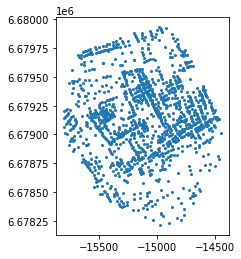

In [28]:
difference2['geometry'].plot(markersize=4)

<AxesSubplot:>

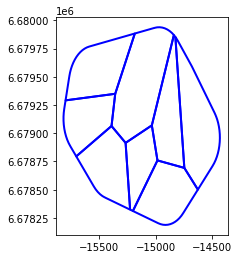

In [29]:
clipped_voronoi_gdf.plot(facecolor="none", edgecolor='blue',linewidth=2)

<AxesSubplot:>

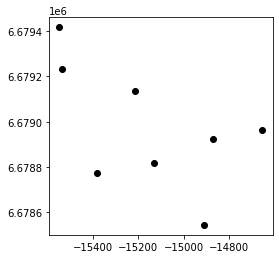

In [30]:
pumps_gdf = gpd.read_file('outputs/pumps.shp').to_crs(epsg=3395)

pumps_gdf.plot(color='black')

## Summary of plots

As an exercise in Pandas plots, let's put together all the plots above. The numbers "331" in the function `add_subplot(331)` mean (rows, columns, graph position or order). `(331)` means "draw me subplots of 3 rows by 3 columns, use position 1".

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

Let's review all the subplots before we overlay them togther in one plot.

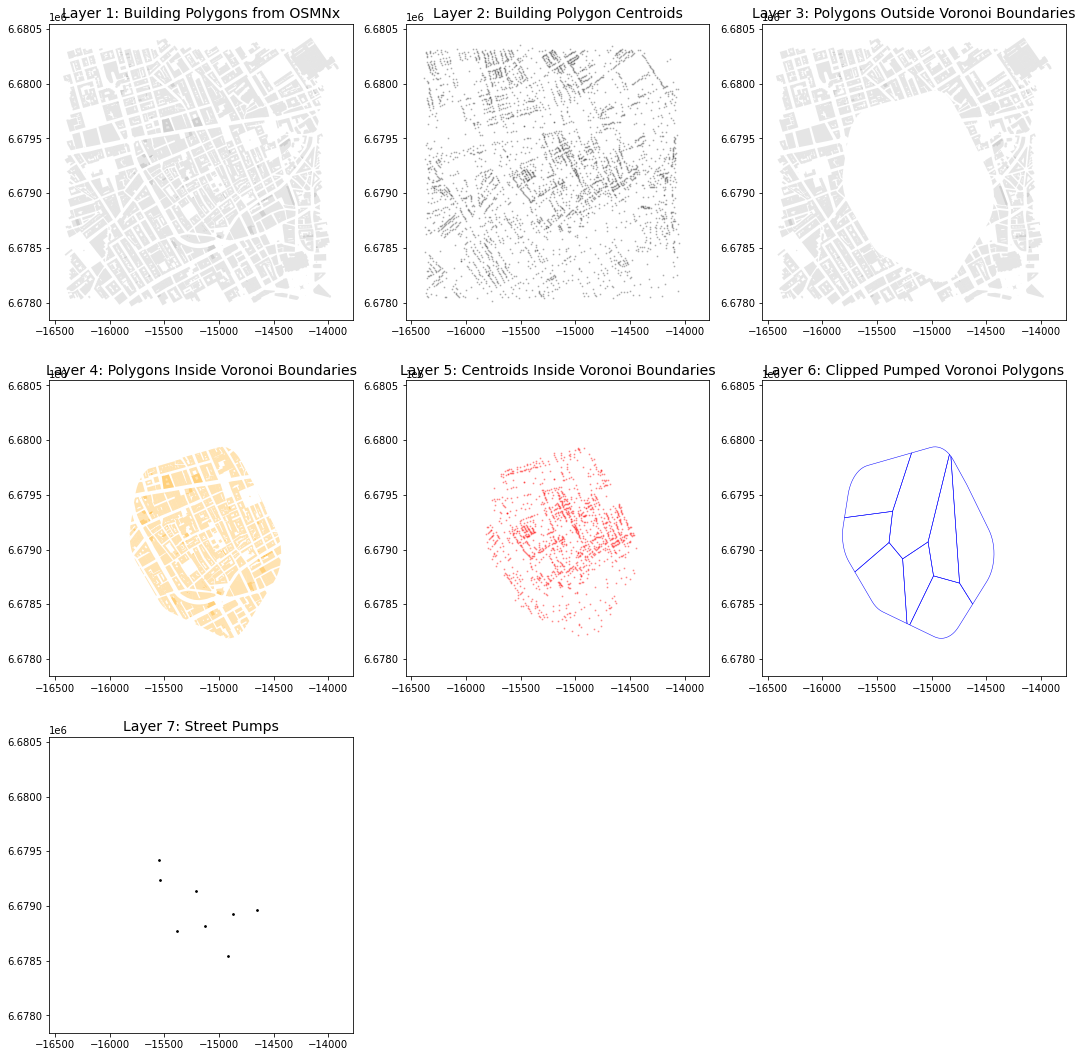

In [32]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(331)
# make all the other subplots share x and y scales with ax1
ax2 = fig.add_subplot(332, sharey=ax1, sharex=ax1)
ax3 = fig.add_subplot(333, sharey=ax1, sharex=ax1)
ax4 = fig.add_subplot(334, sharey=ax1, sharex=ax1)
ax5 = fig.add_subplot(335, sharey=ax1, sharex=ax1)
ax6 = fig.add_subplot(336, sharey=ax1, sharex=ax1)
ax7 = fig.add_subplot(337, sharey=ax1, sharex=ax1)

fs = 14
footprints_gdf['geometry'].plot(color='gray', alpha=0.2, ax=ax1)
ax1.set_title('Layer 1: Building Polygons from OSMNx', fontsize=fs)

footprints_centroid_gdf.geometry.plot(color='black', alpha=0.2, markersize=1, ax=ax2)
ax2.set_title('Layer 2: Building Polygon Centroids', fontsize=fs)

difference1.plot(color='gray', alpha=0.2, ax=ax3)
ax3.set_title('Layer 3: Polygons Outside Voronoi Boundaries', fontsize=fs)

intersection.plot(color='orange', alpha=0.3, ax=ax4)
ax4.set_title('Layer 4: Polygons Inside Voronoi Boundaries', fontsize=fs)

difference2['geometry'].plot(color='red', alpha=0.3, markersize=1, ax=ax5)
ax5.set_title('Layer 5: Centroids Inside Voronoi Boundaries', fontsize=fs)

clipped_voronoi_gdf.plot(facecolor="none", edgecolor='blue', linewidth=0.5, ax=ax6)
ax6.set_title('Layer 6: Clipped Pumped Voronoi Polygons', fontsize=fs)

pumps_gdf.plot(color='black', ax=ax7, markersize=3)
ax7.set_title('Layer 7: Street Pumps', fontsize=fs)

plt.tight_layout()
plt.show()

### Put all the subplots together, layer by layer

Let's now add the subplots layer by layer to create a final plot.

Text(0.5, 114.0, 'Longitude')

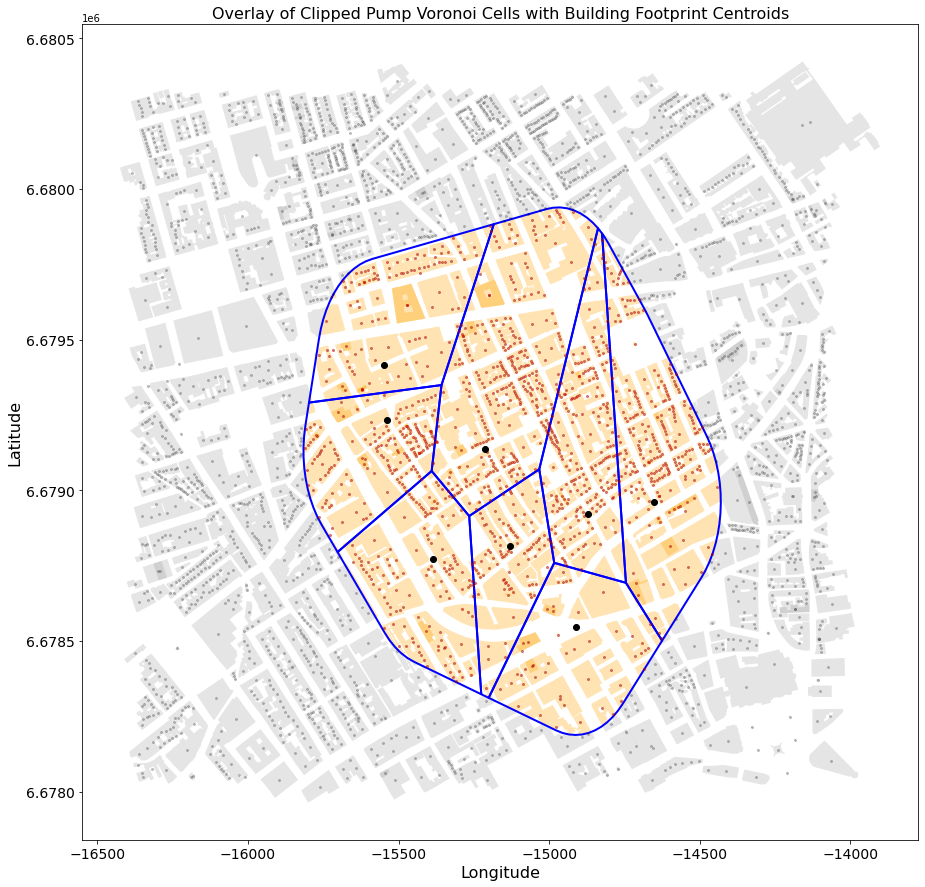

In [33]:
fig, ax = plt.subplots(figsize=(15,15))

# BUILDING FOOTPRINTS POLYGONS LAYER
# layer 1: building footprint polygons minus footprint polygons inside Voronoi cells
difference1['geometry'].plot(color='gray', ax=ax, alpha=0.2)
# layer 2: building footprint polygons that fit within Voronoi cells
intersection.plot(ax=ax, color='orange', linewidth=2, alpha=0.3)

# VORONOI POLYGONS
# layer 3: Voronoi cells from pumps, no fill color
clipped_voronoi_gdf.plot(ax=ax, facecolor="none", edgecolor='blue',linewidth=2)

# BUILDING FOOTPRINTS CENTROID, POINTS LAYER
# layer 4: black points, outside Voronoi cells
footprints_centroid_gdf.geometry.plot(color='black', ax=ax, alpha=0.2, markersize=4)
# layer 5: red points, inside Voronoi cells
difference2['geometry'].plot(color='red', ax=ax, alpha=0.3, markersize=4)
pumps_gdf.plot(color='black', ax=ax)

ax.set_title('Overlay of Clipped Pump Voronoi Cells with Building Footprint Centroids', \
             fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)

Orange or gray polygons are the building footprints. Grey or red dots represent the building footprint centroids.

## TBC: Reuse the code for identifying death locations within Voronoi cells

In [34]:
%run resources/points_in_polygons.py

<Figure size 432x288 with 0 Axes>

In [35]:
# Read the data.
polygons = clipped_voronoi_gdf
points = footprints_centroid_gdf

polygons = points_in_polygons(points, polygons)

polygons

/home/jovyan/work/notebooks/1854-Cholera-Outbreak-London-Advanced-2/resources/points_in_polygons.py:35: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polygons['points_in_polygon'] = gpd.GeoSeries(pts_in_polys)


,vorpt_lat,vorpt_lon,FID,Street,geometry,points_in_polygon
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-15008.714 6679933.633, -14986.067 6...",323
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-15755.504 6678886.043, -15769.854 6...",175
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-15764.064 6679503.520, -15757.904 6...",108
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-14465.257 6679153.299, -14454.588 6...",254
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-14835.933 6679867.746, -14824.464 6...",227
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-15225.480 6678323.299, -15265.465 6...",99
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-14755.051 6678292.781, -14771.209 6...",51
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-15448.443 6678430.903, -15470.469 6...",137


What we have now is a geodataframe with the number of building centroids found in each Voronoi polygon.

In [36]:
clipped_voronoi_buildings_gdf = \
    polygons.rename(columns={'vorpoint_l':'vorpt_lat',\
                             'vorpoint_1':'vorpt_lon',\
                            'points_in_polygon':'num_bldgs'})

clipped_voronoi_buildings_gdf

,vorpt_lat,vorpt_lon,FID,Street,geometry,num_bldgs
0,51.513341,-0.136668,250,Broadwick Street,"POLYGON ((-15008.714 6679933.633, -14986.067 6...",323
1,51.513876,-0.139586,251,Kingly Street,"POLYGON ((-15755.504 6678886.043, -15769.854 6...",175
2,51.514906,-0.139671,252,Ramillies Place,"POLYGON ((-15764.064 6679503.520, -15757.904 6...",108
3,51.512354,-0.131630,253,Dean Street,"POLYGON ((-14465.257 6679153.299, -14454.588 6...",254
4,51.512139,-0.133594,254,Rupert Street,"POLYGON ((-14835.933 6679867.746, -14824.464 6...",227
5,51.511542,-0.135919,255,Bridle Lane,"POLYGON ((-15225.480 6678323.299, -15265.465 6...",99
6,51.510019,-0.133962,256,Regent Street,"POLYGON ((-14755.051 6678292.781, -14771.209 6...",51
7,51.511295,-0.138199,257,Warwick Street,"POLYGON ((-15448.443 6678430.903, -15470.469 6...",137


Let's save these to files.

In [37]:
clipped_voronoi_buildings_gdf.to_file('outputs/clipped_voronoi_buildings.shp')
clipped_voronoi_buildings_gdf.to_file("outputs/clipped_voronoi_buildings_gdf.json", \
                                      driver="GeoJSON")

## Create the barchart for buildings in Voronoi cells 

In [38]:
import pandas as pd

pd.__version__

'1.3.2'

### Buildings per street  pump Voronoi cell

Text(0.5, 0, 'Building Count')

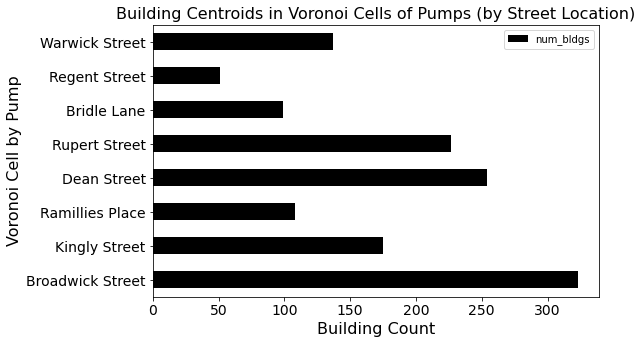

In [41]:
ax = pd.DataFrame(clipped_voronoi_buildings_gdf)\
    .plot.barh(y='num_bldgs', x='Street', color='k', figsize=(8,5))
ax.set_title('Building Centroids in Voronoi Cells of Pumps (by Street Location)', \
             fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_ylabel('Voronoi Cell by Pump', fontsize=16)
ax.set_xlabel('Building Count', \
              fontsize=16)

Which street pump catchment area has the most building footprints (assuming these have been around in 1854)?

## Merge two geodataframes as Pandas dataframes with selected columns to plot two barcharts

In [42]:
death_locations_df = gpd.read_file('outputs/clipped_voronoi_counts.shp')\
    [['FID','points_in_','Street']].rename(columns={'points_in_':'death_locations'})

death_locations_df

,FID,death_locations,Street
0,250,137,Broadwick Street
1,251,38,Kingly Street
2,252,1,Ramillies Place
3,253,0,Dean Street
4,254,41,Rupert Street
5,255,21,Bridle Lane
6,256,0,Regent Street
7,257,12,Warwick Street


In [45]:
buildings_df = \
        clipped_voronoi_buildings_gdf[['FID','num_bldgs']]\
        .rename(columns={'num_bldgs':'buildings'})

buildings_df

,FID,buildings
0,250,323
1,251,175
2,252,108
3,253,254
4,254,227
5,255,99
6,256,51
7,257,137


In [46]:
voronoi_deaths_buildings_df = pd.merge(death_locations_df, buildings_df, \
                                       on='FID', how='inner')

voronoi_deaths_buildings_df

,FID,death_locations,Street,buildings
0,250,137,Broadwick Street,323
1,251,38,Kingly Street,175
2,252,1,Ramillies Place,108
3,253,0,Dean Street,254
4,254,41,Rupert Street,227
5,255,21,Bridle Lane,99
6,256,0,Regent Street,51
7,257,12,Warwick Street,137


### Plotting the two barcharts together...

Text(0.5, 22.200000000000003, 'Point Count')

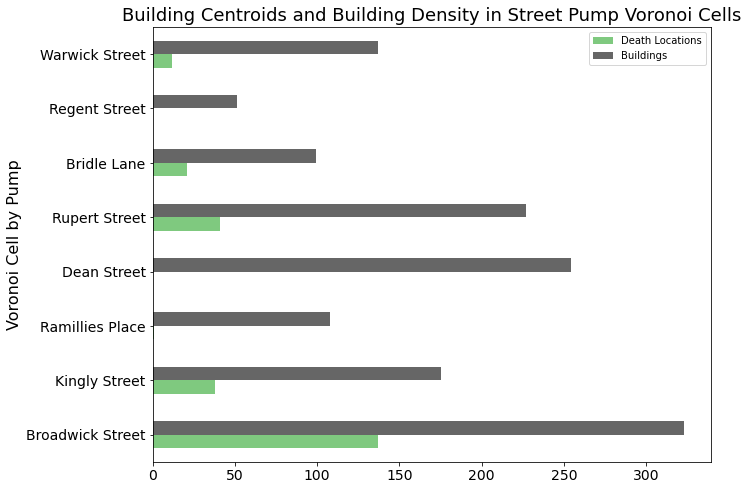

In [47]:
import matplotlib.pyplot as plt

ax1 = voronoi_deaths_buildings_df[['death_locations',\
                                  'buildings',\
                                  'Street']]\
    .rename(columns={'death_locations':'Death Locations',\
                    'buildings':'Buildings',\
                    'buildings per sq. meter':'Buildings per Sq. Meter'})\
    .plot.barh(figsize=(10,8), x='Street', colormap='Accent')


ax1.set_title('Building Centroids and Building Density in Street Pump Voronoi Cells', \
             fontsize=18)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax1.set_ylabel('Voronoi Cell by Pump', fontsize=16)
ax.set_xlabel('Point Count', \
              fontsize=16)


## Next Steps - Challenge

What's left to do is to plot the subplots on folium - do you think you can figure that out?

## References

1. Geopandas SJoin: http://geopandas.org/reference/geopandas.sjoin.html
2. Geopandas Overlay Set Operations: http://geopandas.org/set_operations.html
3. Pandas visualization guide: https://pandas.pydata.org/pandas-docs/version/0.25/user_guide/visualization.html
4. Matplotlib color map guide: https://matplotlib.org/examples/color/colormaps_reference.html
5. Stack Overflow reference for multiple plots, odd numbered: https://stackoverflow.com/questions/41025187/matplotlib-add-subplot-odd-number-of-plots